## Explanation: LangGraph Mathematical Agent

The agent is built using LangGraph and LangChain to combine a large language model (LLM) with custom mathematical tools.

- **LLM Integration**: The agent uses OpenAI's GPT-4o model via `ChatOpenAI`. This LLM is responsible for understanding user queries and generating responses.
- **Tool Definition**: Four mathematical functions (`plus`, `substract`, `multiply`, `divide`) are defined and decorated with `@tool`. These allow the agent to perform addition, subtraction, multiplication, and division.
- **System Prompt**: A system prompt instructs the LLM to use these tools for math queries, ensuring that mathematical operations are handled by the dedicated functions rather than the LLM's internal logic.
- **Graph Construction**: The agent is structured as a state graph:
  - The conversation state is managed and trimmed to avoid token overflow.
  - The graph has nodes for the chatbot (LLM) and tool execution.
  - Conditional logic routes requests: if a tool is needed, the agent calls the appropriate function; otherwise, it ends the conversation.
- **Workflow**:
  1. The user sends a message.
  2. The LLM interprets the query and decides if a tool call is required.
  3. If so, the relevant tool is invoked and the result is returned.
  4. The agent continues the conversation or ends it based on the context.

This design ensures that general queries are answered by the LLM, while mathematical operations are handled by reliable, predefined functions, providing a seamless conversational experience.

In [1]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool
import json
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langchain_core.messages import trim_messages

In [2]:
# ============================================================================
# SETUP: Import LLM Helper Functions
# ============================================================================
# We use helper functions to create LLM instances with proper configuration
# These functions handle API key loading and model configuration

import os
import sys

# Add parent directory to path for importing helpers
sys.path.append(os.path.abspath("../.."))

# Import our LLM factory functions
# - get_groq_llm(): Creates a Groq-hosted LLM (fast inference)
# - get_openai_llm(): Creates an OpenAI GPT model
from helpers.utils import get_groq_llm, get_openai_llm

print("LLM helpers imported successfully!")

# ============================================================================
# CREATE THE LLM AND CHATBOT GRAPH
# ============================================================================

# -----------------------------------------------------------------------------
# Step 1: Initialize the LLM
# We use Groq for fast inference, but you can swap to OpenAI
# -----------------------------------------------------------------------------
llm = get_groq_llm()  # Fast, open-source models hosted by Groq
# Alternative: llm = get_openai_llm()  # OpenAI's GPT models

print(f"LLM initialized: {llm.model_name if hasattr(llm, 'model_name') else 'Groq LLM'}")

LLM helpers imported successfully!
LLM initialized: llama-3.3-70b-versatile


In [3]:
@tool
def plus(num1: int, num2: int):
    """Add 2 Numbers"""
    results = num1 + num2
    return results

@tool
def substract(num1: int, num2: int):
    """Substract 2 Numbers"""
    results = num1 - num2
    return results

@tool
def multiply(num1: int, num2: int):
    """Add 2 Numbers"""
    results = num1 * num2
    return results

@tool
def divide(num1: int, num2: int):
    """Divide 2 numbers, with error handling division by zero"""
    if num2 == 0:
        return "Error: Division by zero"
    results = num1 / num2
    return results

System_Prompt = """You are a helpful assistant that answers general questions using the LLM, and when asked to perform mathematical operations (addition, subtraction, multiplication, and division), it calls four predefined functions (plus, divide, substract, multiply) for answering. The agent should handle both general and math-related queries seamlessly. For any math related query please call the tools, Dont use LLM inbuild capability to answer any math related query.

Example:
Question: What is 5 plus 3?
Use plus tool.

Question: How much is 8 divided by 2?
Use Divide tool.

"""

# Define the state of the graph, which holds the conversation messages
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Initialize the graph builder with the defined state
graph_builder = StateGraph(State)

# List of tools the agent can use (e.g., fetching stock data, searching the web)
tools = [
    plus,
    substract,
    multiply,
    divide
]

llm_with_tools = llm.bind_tools(tools)

# System message to guide the agent's behavior
SYS_MSG = SystemMessage(content=System_Prompt)

# Define the chatbot node, which processes user input and generates responses
def chatbot(state: State):
    # Trim messages to avoid exceeding token limits
    messages = trim_messages(
        state["messages"],
        max_tokens=127000,
        strategy="last", # keep last 127K tokens in messages
        token_counter=ChatOpenAI(model="gpt-4o"),
        include_system=True, # keep system message always
        allow_partial=True, # trim messages to partial content if needed

    )
    # Invoke the LLM with the system message and trimmed conversation history
    return {"messages": [llm_with_tools.invoke([SYS_MSG] + messages)]}

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Add a node for executing tools (e.g., fetching data, searching the web)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add conditional edges: the chatbot decides whether to use tools or end the conversation
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    ['tools', END]
)

# After using a tool, return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Set the chatbot as the entry point of the graph
graph_builder.set_entry_point("chatbot")

# Compile the graph into a runnable agent
agent = graph_builder.compile()

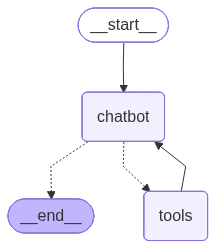

In [4]:
from IPython.display import display, Image

Image(agent.get_graph().draw_mermaid_png())

In [5]:
def call_agent(agent, prompt, user_config={"configurable": {"thread_id": "any"}}):
    events = agent.stream(
        {"messages": [{"role": "user", "content": prompt}]},
        user_config,
        stream_mode="values",
    )

    for event in events:
        event["messages"][-1].pretty_print()

    print()
    print('Final Response:\n')
    display(Markdown(event["messages"][-1].content))

In [6]:
from IPython.display import display, Markdown

query = "What is 5 plus 3"
result = call_agent(agent, query)

================================ Human Message =================================

What is 5 plus 3
================================== Ai Message ==================================
Tool Calls:
  plus (pe0kbv0s0)
 Call ID: pe0kbv0s0
  Args:
    num1: 5
    num2: 3
================================= Tool Message =================================
Name: plus

8
================================== Ai Message ==================================

The answer is 8.

Final Response:



The answer is 8.

## Alternate Approach. Using should_continue

In [0]:
# """
# LangGraph Mathematical Agent
# A conversational agent that handles general questions using an LLM and
# performs mathematical operations using predefined functions.
# """

# import os
# import operator
# from typing import Annotated, Literal, TypedDict
# from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
# from langchain_core.tools import tool
# from langgraph.graph import StateGraph, MessagesState, START, END
# from langgraph.prebuilt import ToolNode
# from langgraph.checkpoint.memory import MemorySaver

# # Choose your LLM provider - uncomment the one you want to use
# # Option 1: Using Groq API
# # from langchain_groq import ChatGroq
# # llm = ChatGroq(
# #     model="llama-3.1-70b-versatile",
# #     api_key=os.getenv("GROQ_API_KEY"),  # Set your API key as environment variable
# #     temperature=0
# # )

# # Option 2: Using Google Gemini API
# # from langchain_google_genai import ChatGoogleGenerativeAI
# # llm = ChatGoogleGenerativeAI(
# #     model="gemini-1.5-pro",
# #     google_api_key=os.getenv("GOOGLE_API_KEY"),
# #     temperature=0
# # )

# # Option 3: Using Ollama (Local LLM)
# # from langchain_ollama import ChatOllama
# # llm = ChatOllama(
# #     model="llama3.1",
# #     temperature=0
# # )

# # Option 4: Using OpenAI
# # from langchain_openai import ChatOpenAI
# # llm = ChatOpenAI(
# #     model="gpt-4o-mini",
# #     api_key=os.getenv("OPENAI_API_KEY"),
# #     temperature=0
# # )

# llm = ChatOpenAI(model="gpt-4o", temperature=0)

# # ============================================================================
# # MATHEMATICAL OPERATION TOOLS
# # ============================================================================

# @tool
# def plus(a: float, b: float) -> float:
#     """Add two numbers together.
    
#     Args:
#         a: The first number
#         b: The second number
        
#     Returns:
#         The sum of a and b
#     """
#     result = a + b
#     print(f"[TOOL CALL] plus({a}, {b}) = {result}")
#     return result


# @tool
# def subtract(a: float, b: float) -> float:
#     """Subtract the second number from the first number.
    
#     Args:
#         a: The number to subtract from
#         b: The number to subtract
        
#     Returns:
#         The difference between a and b
#     """
#     result = a - b
#     print(f"[TOOL CALL] subtract({a}, {b}) = {result}")
#     return result


# @tool
# def multiply(a: float, b: float) -> float:
#     """Multiply two numbers together.
    
#     Args:
#         a: The first number
#         b: The second number
        
#     Returns:
#         The product of a and b
#     """
#     result = a * b
#     print(f"[TOOL CALL] multiply({a}, {b}) = {result}")
#     return result


# @tool
# def divide(a: float, b: float) -> float:
#     """Divide the first number by the second number.
    
#     Args:
#         a: The dividend (number to be divided)
#         b: The divisor (number to divide by)
        
#     Returns:
#         The quotient of a divided by b
        
#     Raises:
#         ValueError: If attempting to divide by zero
#     """
#     if b == 0:
#         error_msg = "Error: Division by zero is not allowed"
#         print(f"[TOOL CALL] divide({a}, {b}) - {error_msg}")
#         raise ValueError(error_msg)
    
#     result = a / b
#     print(f"[TOOL CALL] divide({a}, {b}) = {result}")
#     return result


# # ============================================================================
# # AGENT STATE AND GRAPH SETUP
# # ============================================================================

# # Define the tools available to the agent
# tools = [plus, subtract, multiply, divide]

# # Bind tools to the LLM
# llm_with_tools = llm.bind_tools(tools)


# def should_continue(state: MessagesState) -> Literal["tools", "end"]:
#     """Determine whether to continue to tools or end the conversation.
    
#     This function checks if the last message from the LLM contains tool calls.
#     If it does, we route to the tools node. Otherwise, we end the conversation.
    
#     Args:
#         state: The current state containing all messages
        
#     Returns:
#         "tools" if tool calls are present, "end" otherwise
#     """
#     messages = state["messages"]
#     last_message = messages[-1]
    
#     # Check if the last message has tool calls
#     if hasattr(last_message, "tool_calls") and last_message.tool_calls:
#         print(f"[ROUTING] Tool calls detected: {len(last_message.tool_calls)} call(s)")
#         return "tools"
    
#     print("[ROUTING] No tool calls - ending conversation")
#     return "end"


# def call_model(state: MessagesState) -> dict:
#     """Call the LLM with the current state.
    
#     This function invokes the language model with the conversation history
#     and returns the response, which may include tool calls for mathematical operations.
    
#     Args:
#         state: The current state containing all messages
        
#     Returns:
#         A dictionary with the new message to add to state
#     """
#     messages = state["messages"]
#     print(f"[LLM] Processing {len(messages)} message(s)")
    
#     response = llm_with_tools.invoke(messages)
    
#     # Return the response to be added to the state
#     return {"messages": [response]}


# # ============================================================================
# # BUILD THE GRAPH
# # ============================================================================

# def create_agent_graph():
#     """Create and compile the LangGraph agent.
    
#     The graph structure:
#     1. START -> agent: Initial entry point
#     2. agent -> should_continue: Decision point
#     3. should_continue -> tools: If tool calls are needed
#     4. should_continue -> END: If no tool calls needed
#     5. tools -> agent: Return to agent after tool execution
    
#     Returns:
#         A compiled StateGraph ready for execution
#     """
#     # Initialize the graph with MessagesState
#     workflow = StateGraph(MessagesState)
    
#     # Add nodes to the graph
#     workflow.add_node("agent", call_model)
#     workflow.add_node("tools", ToolNode(tools))
    
#     # Set the entry point
#     workflow.add_edge(START, "agent")
    
#     # Add conditional edges
#     workflow.add_conditional_edges(
#         "agent",
#         should_continue,
#         {
#             "tools": "tools",
#             "end": END
#         }
#     )
    
#     # Add edge from tools back to agent
#     workflow.add_edge("tools", "agent")
    
#     # Compile the graph with memory
#     memory = MemorySaver()
#     app = workflow.compile(checkpointer=memory)
    
#     return app


# # ============================================================================
# # MAIN EXECUTION
# # ============================================================================

# def run_agent(query: str, app, thread_id: str = "default"):
#     """Run the agent with a given query.
    
#     Args:
#         query: The user's question or request
#         app: The compiled LangGraph application
#         thread_id: Unique identifier for the conversation thread
#     """
#     print("\n" + "="*80)
#     print(f"USER QUERY: {query}")
#     print("="*80)
    
#     # Configure the thread
#     config = {"configurable": {"thread_id": thread_id}}
    
#     # Create the input message
#     input_messages = [HumanMessage(content=query)]
    
#     # Stream the response
#     for event in app.stream({"messages": input_messages}, config, stream_mode="values"):
#         # Get the last message in the current state
#         last_message = event["messages"][-1]
        
#         # Only print AI messages (final responses)
#         if isinstance(last_message, AIMessage) and not hasattr(last_message, "tool_calls"):
#             print("\n" + "-"*80)
#             print("AGENT RESPONSE:")
#             print("-"*80)
#             print(last_message.content)
#             print("-"*80 + "\n")
#         elif isinstance(last_message, AIMessage) and last_message.tool_calls:
#             print(f"[AGENT] Preparing to call {len(last_message.tool_calls)} tool(s)")


# def main():
#     """Main function to demonstrate the mathematical agent."""
    
#     print("""
#     ╔══════════════════════════════════════════════════════════════════════╗
#     ║         LangGraph Mathematical Agent - Demonstration                 ║
#     ║                                                                      ║
#     ║  This agent can:                                                     ║
#     ║  1. Answer general questions using an LLM                           ║
#     ║  2. Perform mathematical operations using specialized tools         ║
#     ║     - Addition (plus)                                               ║
#     ║     - Subtraction (subtract)                                        ║
#     ║     - Multiplication (multiply)                                     ║
#     ║     - Division (divide)                                             ║
#     ╚══════════════════════════════════════════════════════════════════════╝
#     """)
    
#     # Create the agent
#     print("Initializing agent...")
#     app = create_agent_graph()
#     print("Agent initialized successfully!\n")
    
#     # Test cases demonstrating different capabilities
#     test_queries = [
#         # Mathematical operations
#         "What is 5 plus 3?",
#         "Calculate 100 minus 45",
#         "How much is 7 multiplied by 8?",
#         "What's 144 divided by 12?",
        
#         # Complex mathematical queries
#         "I need to add 25.5 and 30.75",
#         "Can you multiply 15 by 4 for me?",
        
#         # Edge case - division by zero
#         "What happens if I divide 10 by 0?",
        
#         # General knowledge questions
#         "What is the capital of France?",
#         "Explain what artificial intelligence is in simple terms",
#         "Who wrote Romeo and Juliet?",
        
#         # Mixed context
#         "I'm planning a dinner for 8 people. If each pizza serves 4 people, how many pizzas do I need?"
#     ]
    
#     # Run each test query
#     for i, query in enumerate(test_queries, 1):
#         run_agent(query, app, thread_id=f"test_{i}")
        
#         # Add a small pause between queries for readability
#         if i < len(test_queries):
#             input("\nPress Enter to continue to next query...")
    
#     print("\n" + "="*80)
#     print("DEMONSTRATION COMPLETE")
#     print("="*80)
    
#     # Interactive mode
#     print("\n\nEntering interactive mode. Type 'quit' or 'exit' to end.\n")
    
#     while True:
#         try:
#             user_input = input("You: ").strip()
            
#             if user_input.lower() in ['quit', 'exit', 'q']:
#                 print("Goodbye!")
#                 break
            
#             if not user_input:
#                 continue
            
#             run_agent(user_input, app, thread_id="interactive")
            
#         except KeyboardInterrupt:
#             print("\n\nGoodbye!")
#             break
#         except Exception as e:
#             print(f"\nError: {str(e)}\n")


# # if __name__ == "__main__":
# #     main()


In [0]:
# query = "What is 5 plus 3"
# app = create_agent_graph()
# run_agent(query, app, thread_id=f"u01")

In [0]:
# Image(app.get_graph().draw_mermaid_png())